In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt
import re
import pickle
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from keras import Sequential
from keras.layers import LSTM, SimpleRNN, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sentence_transformers import SentenceTransformer

# nltk.download('punkt')

## 1 - Load the data
(https://data.world/crowdflower/disasters-on-social-media/workspace/file?filename=socialmedia-disaster-tweets-DFE.csv)

In [6]:
df = pd.read_csv("data/original_tweets.csv", encoding='ISO-8859-1')[["choose_one", "text", "location", "keyword"]]
df['target'] = (df['choose_one'] == 'Relevant').astype(np.int8)
df = df.drop(["choose_one"], axis=1)

In [10]:
df

,text,location,keyword,target
0,Just happened a terrible car crash,NaN,NaN,1
1,Our Deeds are the Reason of this #earthquake M...,NaN,NaN,1
2,"Heard about #earthquake is different cities, s...",NaN,NaN,1
3,"there is a forest fire at spot pond, geese are...",NaN,NaN,1
4,Forest fire near La Ronge Sask. Canada,NaN,NaN,1
...,...,...,...,...
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,NaN,NaN,1
10872,Police investigating after an e-bike collided ...,NaN,NaN,1
10873,The Latest: More Homes Razed by Northern Calif...,NaN,NaN,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,NaN,1


In [9]:
df.sample(5)

,text,location,keyword,target
9224,Turkish troops killed in Kurdish militant 'sui...,USA,suicide%20bombing,1
2631,#News Bin Laden family plane crashed after 'av...,NaN,crashed,1
105,BigRigRadio Live Accident Awareness,Australia,accident,1
5659,Thankkk U all Soo much for Flooding my Notific...,"Nadiad ,Gujarat , India!!",flooding,0
4076,.POTUS #StrategicPatience is a strategy for #G...,Pedophile hunting ground,displaced,0


## 2 - Data Analysis

### Duplicate values

In [5]:
sum(df.duplicated())

101

### Missing values

<AxesSubplot:>

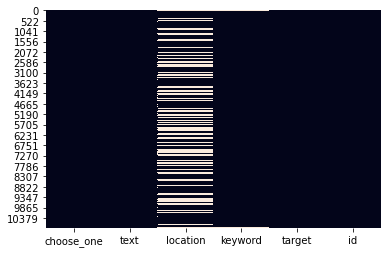

In [7]:
sns.heatmap(df.isna(), cbar=False)

In [8]:
df.isna().sum() * 100 / df.shape[0]

choose_one     0.000000
text           0.000000
location      33.225058
keyword        0.807425
target         0.000000
id             0.000000
dtype: float64

### Create meta features

**word_count** number of words in text
**unique_word_count** number of unique words in text
**stop_word_count** number of stop words in text
**url_count number** of urls in text
**mean_word_length** average character count in words
**char_count** number of characters in text
**punctuation_count** number of punctuations in text
**hashtag_count** number of hashtags (#) in text
**mention_count** number of mentions (@) in text


In [81]:
%%capture
stopwords = set(stopwords.words("english"))

df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# stop_word_count
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

# url_count
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [10]:
df

,choose_one,text,location,keyword,target,id,word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count
0,Relevant,Just happened a terrible car crash,NaN,NaN,1,0,6,2,0,4.833333,34,0
1,Relevant,Our Deeds are the Reason of this #earthquake M...,NaN,NaN,1,1,13,6,0,4.384615,69,1
2,Relevant,"Heard about #earthquake is different cities, s...",NaN,NaN,1,2,9,2,0,6.222222,64,3
3,Relevant,"there is a forest fire at spot pond, geese are...",NaN,NaN,1,3,19,9,0,4.105263,96,2
4,Relevant,Forest fire near La Ronge Sask. Canada,NaN,NaN,1,4,7,0,0,4.571429,38,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10871,Relevant,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,NaN,NaN,1,10871,8,2,1,7.250000,65,11
10872,Relevant,Police investigating after an e-bike collided ...,NaN,NaN,1,10872,19,5,0,6.263158,137,5
10873,Relevant,The Latest: More Homes Razed by Northern Calif...,NaN,NaN,1,10873,13,3,1,6.307692,94,7
10874,Relevant,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,NaN,1,10874,7,0,1,8.428571,65,7


### Distribution of features and classes

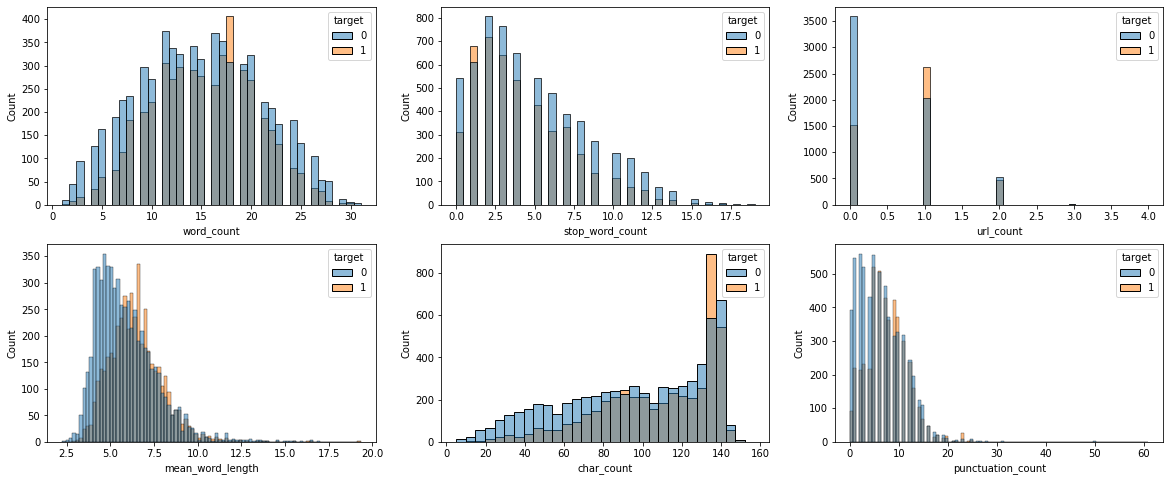

In [11]:
meta_columns = ["word_count", "stop_word_count", "url_count", "mean_word_length", "char_count", "punctuation_count"]

fig, axes = plt.subplots(figsize=(20, 8), ncols=3, nrows=2)
axes = axes.ravel()
for col, ax in zip(meta_columns, axes):
    sns.histplot(data=df, x=col, hue="target", ax=ax)

<AxesSubplot:xlabel='target', ylabel='Count'>

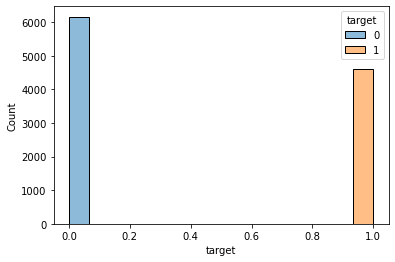

In [12]:
sns.histplot(data=df, x="target", hue="target")

### Create N-Gram

## 3 - Pre processing

### Text Cleaning
- Remove duplicate values
- url / html
- emojis
- ponctuation
- Spelling correction
- Lower character
- Eliminate stopwords
- Impute missing values

In [82]:
def remove_duplicate():
    df.drop_duplicates(inplace=True)
    df['id'] = df.index.astype(np.int16)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct_and_lower(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table).lower()

spell = SpellChecker()
def correct_spellings_and_stopwords(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in stopwords:
            continue
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def impute_missing_values(_df):
    _df["text"] = _df["clean_text"].fillna("unknown")
    _df["clean_location"] = _df["location"].fillna("unknown")
    return _df

In [83]:
%%capture
remove_duplicate()
df["clean_text"] = df["text"].apply(remove_url)
df["clean_text"] = df["clean_text"].apply(remove_html)
df["clean_text"] = df["clean_text"].apply(remove_emoji)
df["clean_text"] = df["clean_text"].apply(remove_punct_and_lower)
df["clean_text"] = df["clean_text"].apply(correct_spellings_and_stopwords)
df = impute_missing_values(df)

In [84]:
%%capture
df['clean_word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

# stop_word_count
df['clean_stop_word_count'] = df['clean_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

# url_count
df['clean_url_count'] = df['clean_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df['clean_mean_word_length'] = df['clean_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['clean_char_count'] = df['clean_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['clean_punctuation_count'] = df['clean_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

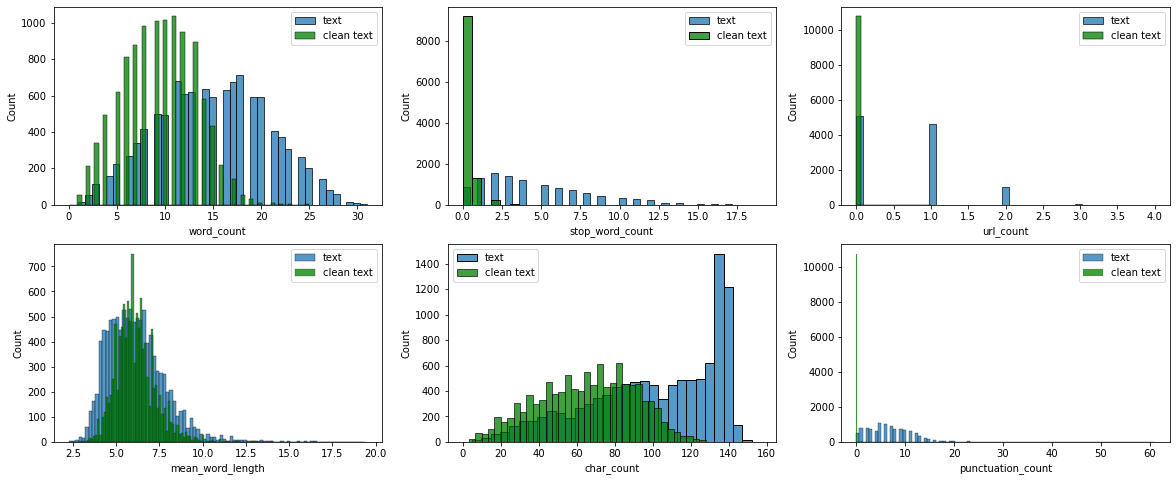

In [16]:
fig, axes = plt.subplots(figsize=(20, 8), ncols=3, nrows=2)
axes = axes.ravel()
for col, ax in zip(meta_columns, axes):
    clean_col = "".join(("clean_", col))
    cols = [col, clean_col]
    for co in cols:
        color = "green" if co == cols[-1] else None
        label = "clean text" if co == cols[-1] else "text"
        sns.histplot(data=df, x=co, ax=ax, color=color, label=label)
        ax.legend()

### Tokenization
Operation to convert sentences to array. This must be done before stemming/lemmatize

In [87]:
def tokenize(_df):
    tokens = []
    for txt in df['clean_text']:
        words = [word for word in word_tokenize(txt) if word.isalpha() == 1]
        tokens.append(words)
    _df["tokenized_text"] = tokens
    return _df

df = tokenize(df)

In [88]:
df

,choose_one,text,location,keyword,target,word_count,stop_word_count,url_count,mean_word_length,char_count,...,id,clean_text,clean_location,clean_word_count,clean_stop_word_count,clean_url_count,clean_mean_word_length,clean_char_count,clean_punctuation_count,tokenized_text
0,Relevant,happened terrible car crash,NaN,NaN,1,6,2,0,4.833333,34,...,0,happened terrible car crash,unknown,4,0,0,6.000000,27,0,"[happened, terrible, car, crash]"
1,Relevant,deeds reason earthquake may allah forgive us,NaN,NaN,1,13,6,0,4.384615,69,...,1,deeds reason earthquake may allah forgive us,unknown,7,0,0,5.428571,44,0,"[deeds, reason, earthquake, may, allah, forgiv..."
2,Relevant,heard earthquake different cities stay safe ev...,NaN,NaN,1,9,2,0,6.222222,64,...,2,heard earthquake different cities stay safe ev...,unknown,7,0,0,6.571429,52,0,"[heard, earthquake, different, cities, stay, s..."
3,Relevant,forest fire spot pond geese fleeing across str...,NaN,NaN,1,19,9,0,4.105263,96,...,3,forest fire spot pond geese fleeing across str...,unknown,10,0,0,5.200000,61,0,"[forest, fire, spot, pond, geese, fleeing, acr..."
4,Relevant,forest fire near la range ask canada,NaN,NaN,1,7,0,0,4.571429,38,...,4,forest fire near la range ask canada,unknown,7,0,0,4.285714,36,0,"[forest, fire, near, la, range, ask, canada]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,Relevant,m194 0104 utc5km volcano hawaii,NaN,NaN,1,8,2,1,7.250000,65,...,10871,m194 0104 utc5km volcano hawaii,unknown,5,0,0,5.400000,31,0,"[volcano, hawaii]"
10872,Relevant,police investigating bike collided car little ...,NaN,NaN,1,19,5,0,6.263158,137,...,10872,police investigating bike collided car little ...,unknown,14,0,0,6.928571,110,0,"[police, investigating, bike, collided, car, l..."
10873,Relevant,latest homes razed northern california wildfir...,NaN,NaN,1,13,3,1,6.307692,94,...,10873,latest homes razed northern california wildfir...,unknown,8,0,0,6.125000,56,0,"[latest, homes, razed, northern, california, w..."
10874,Relevant,meg issues hazardous weather outlook how,NaN,NaN,1,7,0,1,8.428571,65,...,10874,meg issues hazardous weather outlook how,unknown,6,1,0,5.833333,40,0,"[meg, issues, hazardous, weather, outlook, how]"


### Stemming & Lemmatization
Both perform a text pre processing which aims to reduce words to their common form.
Those tasks iterates over each word and keep his semantic origin.

**Stemming**
Fast execution and implementation is straight forward

**Lemmatization**
Slower execution and harder implementation.
Same process as stemming with part-of-speech implementation (POS). This way the process takes in consideration the type of the word in the sentence (subject verb complement).
Results are generaly slightly better with this method.

https://www.baeldung.com/cs/stemming-vs-lemmatization

In [89]:
stemmer = PorterStemmer()
df["stemmed_text"] = df['tokenized_text'].apply(lambda x: (" ".join([stemmer.stem(y) for y in x]).strip()))
df.reset_index(drop=True, inplace=True)

In [90]:
df

,choose_one,text,location,keyword,target,word_count,stop_word_count,url_count,mean_word_length,char_count,...,clean_text,clean_location,clean_word_count,clean_stop_word_count,clean_url_count,clean_mean_word_length,clean_char_count,clean_punctuation_count,tokenized_text,stemmed_text
0,Relevant,happened terrible car crash,NaN,NaN,1,6,2,0,4.833333,34,...,happened terrible car crash,unknown,4,0,0,6.000000,27,0,"[happened, terrible, car, crash]",happen terribl car crash
1,Relevant,deeds reason earthquake may allah forgive us,NaN,NaN,1,13,6,0,4.384615,69,...,deeds reason earthquake may allah forgive us,unknown,7,0,0,5.428571,44,0,"[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquak may allah forgiv us
2,Relevant,heard earthquake different cities stay safe ev...,NaN,NaN,1,9,2,0,6.222222,64,...,heard earthquake different cities stay safe ev...,unknown,7,0,0,6.571429,52,0,"[heard, earthquake, different, cities, stay, s...",heard earthquak differ citi stay safe everyon
3,Relevant,forest fire spot pond geese fleeing across str...,NaN,NaN,1,19,9,0,4.105263,96,...,forest fire spot pond geese fleeing across str...,unknown,10,0,0,5.200000,61,0,"[forest, fire, spot, pond, geese, fleeing, acr...",forest fire spot pond gees flee across street ...
4,Relevant,forest fire near la range ask canada,NaN,NaN,1,7,0,0,4.571429,38,...,forest fire near la range ask canada,unknown,7,0,0,4.285714,36,0,"[forest, fire, near, la, range, ask, canada]",forest fire near la rang ask canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10770,Relevant,m194 0104 utc5km volcano hawaii,NaN,NaN,1,8,2,1,7.250000,65,...,m194 0104 utc5km volcano hawaii,unknown,5,0,0,5.400000,31,0,"[volcano, hawaii]",volcano hawaii
10771,Relevant,police investigating bike collided car little ...,NaN,NaN,1,19,5,0,6.263158,137,...,police investigating bike collided car little ...,unknown,14,0,0,6.928571,110,0,"[police, investigating, bike, collided, car, l...",polic investig bike collid car littl portug bi...
10772,Relevant,latest homes razed northern california wildfir...,NaN,NaN,1,13,3,1,6.307692,94,...,latest homes razed northern california wildfir...,unknown,8,0,0,6.125000,56,0,"[latest, homes, razed, northern, california, w...",latest home raze northern california wildfir a...
10773,Relevant,meg issues hazardous weather outlook how,NaN,NaN,1,7,0,1,8.428571,65,...,meg issues hazardous weather outlook how,unknown,6,1,0,5.833333,40,0,"[meg, issues, hazardous, weather, outlook, how]",meg issu hazard weather outlook how


### Vectorization / embedding
Numeric representation of the text using vectors.
There is this low level library that is used to perform cosine similariry to define vectors therefore represents words

In [3]:
def save_xy():
    with open('data/X.pickle', 'wb') as handle:
        pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('data/y.pickle', 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('data/X_metaFeatures.pickle', 'wb') as handle:
        pickle.dump(np.concatenate((X, df[["url_count", "mean_word_length", "char_count"]]), axis=1), handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_xy():
    with open('data/X.pickle', 'rb') as fx, open('data/y.pickle', 'rb') as fy:
        _x, _y = pickle.load(fx), pickle.load(fy)
    return _x, _y

In [30]:
# model = SentenceTransformer('all-mpnet-base-v2')
# X = model.encode(df["stemmed_text"])
# save_xy()

In [103]:
X, y = load_xy()

### Split data - Train & Test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.reshape(-1, 1, 768)
X_test = X_test.reshape(-1, 1, 768)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

## 3 - Deep Learning - Classification

In [62]:
# declare fews variables

nb_epochs = 30

# it will contains every models that gonna be fit
models = []

# it will contains every architecture of each model
models_architecture = []

# prevent overfitting
callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=.025, mode="min")

In [33]:
# Helpers function

def build_model(nb_hidden_layer, perceptrons, learning_rate, dropout=0, architecture="lstm"):
    """
    Function that build a model, used to create multiple models dynamically
    :param nb_hidden_layer: int, number of hidden layer
    :param perceptrons: list, schema of the architecure eg. (16, 32, 64) suitable for 3 hiddens layer
    :param learning_rate: float, lr for the adam optimizer
    :param dropout: float
    :param architecture: str, lstm/rnn architecture ?
    """
    new_architecture = {"Nb. hidden layers": nb_hidden_layer, "learning rate": learning_rate, "dropout": dropout,
                        "Layer 1": perceptrons[0], "Layer 2": perceptrons[1], "Layer 3": perceptrons[2],}
    models_architecture.append(new_architecture)

    optimzer = Adam(learning_rate=learning_rate)
    model = Sequential()
    for layer, unit in zip(range(nb_hidden_layer), perceptrons):
        if architecture == "lstm":
            model.add(LSTM(unit, dropout=dropout, return_sequences=True))
        elif architecture == "rnn":
            model.add(SimpleRNN(unit, return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])
    models.append(model)

def show_result(_df, count=8):
    """
    Used to display result of all the models after their training
    :param steps: dataframe, contains all the history of the training for each model
    """
    _df = _df.head(count)

    fig, axes = plt.subplots(figsize=(25, 13), nrows=int(count/4), ncols=4, dpi=70)
    fig.tight_layout(h_pad=15, w_pad=5)
    axes = axes.ravel()

    for ax, (i, row) in zip(axes, _df.iterrows()):
        arch = f'model n°{row["model_id"]}\n nb. layer:{row["Nb. hidden layers"]}, learning rate:{row["learning rate"]}, dropout:{row["dropout"]}\n layers:{row["Layer 1"],row["Layer 2"],row["Layer 3"]}'
        ax.set_title(arch)
        ax.set(xlabel='Epochs', ylabel='Metrics')
        sns.lineplot(x=range(len(row["step_loss"])), y=row["step_loss"], label="train loss", ax=ax)
        sns.lineplot(x=range(len(row["step_loss"])), y=row["step_val_loss"], label="val loss", ax=ax)
        sns.lineplot(x=range(len(row["step_loss"])), y=row["step_acc"], label="train accuracy", ax=ax)
        sns.lineplot(x=range(len(row["step_loss"])), y=row["step_val_acc"], label="val accuracy", ax=ax)


## Architecture LSTM

Using differents LSTM architectures to get the best model and compare them:
84 unique models depending on the number of layer, learning rate, dropout and number of perceptrons.

In [35]:
# declare fews variables before build & train the models
nb_layer = {"lstm": 3, "rnn": 2}
learning_rates = {"lstm": [.001, .0001, .00001], "rnn":[.001, .005, .0001]}
dropout = [0, .2]
units = {"lstm": [[(32, 0, 0), (64, 0, 0), (128, 0, 0), (256, 0, 0), (1024, 0, 0)],
         [(32, 32, 0), (64, 64, 0), (128, 128, 0), (32, 256, 0), (256, 256, 0), (1024, 1024, 0)],
         [(32, 32, 32), (256, 256, 256), (1024, 1024, 1024)]],
         "rnn": [[(32, 0, 0), (64, 0, 0), (128, 0, 0), (256, 0, 0), (1024, 0, 0)],
                 [(32, 32, 0), (64, 64, 0)]]}
steps = []

In [37]:
def build_models(architecture):
    for layer in range(1, nb_layer[architecture]+1):
        for unit in units[architecture][layer-1]:
            for lr in learning_rates[architecture]:
                for dp in dropout:
                    build_model(layer, unit, lr, dp, architecture=architecture)

def fit_models():
    for model in tqdm(models):
        steps.append(model.fit(X_train, y_train, epochs=nb_epochs, validation_split=.2, verbose=0, callbacks=callback).history)

def get_result():
    _df = pd.DataFrame(models_architecture)
    _df['model_id'] = _df.index.astype(np.int16)
    loss, val_loss, acc, val_acc, test_loss, test_acc = [], [], [], [], [], []
    step_loss, step_val_loss, step_acc, step_val_acc = [], [], [], []
    for step, model in zip(steps, models):
        loss.append(step["loss"][-1])
        val_loss.append(step["val_loss"][-1])
        acc.append(step["accuracy"][-1])
        val_acc.append(step["val_accuracy"][-1])
        test_result = model.evaluate(X_test, y_test, verbose=0)
        test_loss.append(test_result[0])
        test_acc.append(test_result[1])

        step_loss.append(step["loss"])
        step_val_loss.append(step["val_loss"])
        step_acc.append(step["accuracy"])
        step_val_acc.append(step["val_accuracy"])

    _df["loss"] = loss; _df["val_loss"] = val_loss; _df["accuracy"] = acc; _df["val_accuracy"] = val_acc; _df["test_acc"] = test_acc; _df["test_loss"] = test_loss
    _df["step_loss"] = step_loss; _df["step_val_loss"] = step_val_loss; _df["step_acc"] = step_acc; _df["step_val_acc"] = step_val_acc
    return _df

def save_result(r, arch):
    with open(f'data/{arch}_dataframe_result.pickle', 'wb') as handle:
        pickle.dump(r, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_result(arch):
    with open(f'data/{arch}_dataframe_result.pickle', 'rb') as f:
        _df = pickle.load(f)
    return _df

In [23]:
# build_models(arch="lstm")
# fit_models()

In [24]:
# df_result = get_result()
# df_result = df_result.sort_values(by=["val_accuracy", "test_acc", "val_loss", "test_loss"], ascending=False)
# save_result(df_result, arch="lstm")
df_result = load_result(arch="lstm")

In [25]:
df_result

,Nb. hidden layers,learning rate,dropout,Layer 1,Layer 2,Layer 3,model_id,loss,val_loss,accuracy,val_accuracy,test_acc,test_loss,step_loss,step_val_loss,step_acc,step_val_acc
67,3,0.00100,0.2,32,32,32,67,0.306626,0.481295,0.872535,0.813805,0.796752,0.503648,"[0.5840945243835449, 0.4790229797363281, 0.462...","[0.49169638752937317, 0.4701995849609375, 0.46...","[0.6857598423957825, 0.7862529158592224, 0.791...","[0.7813224792480469, 0.7882830500602722, 0.791..."
49,2,0.00100,0.2,32,256,0,49,0.300319,0.488786,0.869490,0.811485,0.797216,0.511263,"[0.5509409308433533, 0.47029227018356323, 0.45...","[0.48412296175956726, 0.4654847979545593, 0.45...","[0.7143271565437317, 0.7869779467582703, 0.790...","[0.7859628796577454, 0.7929234504699707, 0.796..."
6,1,0.00100,0.0,64,0,0,6,0.274853,0.481966,0.881816,0.807425,0.799536,0.504106,"[0.5460867881774902, 0.46581560373306274, 0.44...","[0.4935968816280365, 0.47039735317230225, 0.45...","[0.7439095377922058, 0.7885730862617493, 0.794...","[0.7865429520606995, 0.7836427092552185, 0.794..."
56,2,0.00010,0.0,256,256,0,56,0.401435,0.449110,0.820911,0.805104,0.797680,0.470197,"[0.6549369096755981, 0.5137321352958679, 0.478...","[0.5747414827346802, 0.49924835562705994, 0.48...","[0.6431264281272888, 0.7623260021209717, 0.776...","[0.7639211416244507, 0.7761020660400391, 0.780..."
74,3,0.00010,0.0,256,256,256,74,0.390595,0.453123,0.826421,0.805104,0.789791,0.474468,"[0.6394615769386292, 0.4891500473022461, 0.466...","[0.5231944918632507, 0.48762941360473633, 0.47...","[0.6299303770065308, 0.7701566219329834, 0.784...","[0.767401397228241, 0.7801623940467834, 0.7882..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,3,0.00100,0.0,256,256,256,72,0.068479,1.581069,0.972158,0.734339,0.721578,1.562223,"[0.5060932636260986, 0.4521705210208893, 0.440...","[0.46960559487342834, 0.46272021532058716, 0.4...","[0.7549303770065308, 0.7987238764762878, 0.803...","[0.7888631224632263, 0.7900232076644897, 0.794..."
34,2,0.00001,0.0,32,32,0,34,0.605034,0.606797,0.723463,0.727378,0.722506,0.603982,"[0.6928883194923401, 0.6922166347503662, 0.691...","[0.6925144195556641, 0.6918303966522217, 0.691...","[0.5503190159797668, 0.5717807412147522, 0.571...","[0.5817865133285522, 0.5742459297180176, 0.574..."
70,3,0.00001,0.0,32,32,32,70,0.598499,0.601262,0.703451,0.702436,0.705800,0.596881,"[0.6929664015769958, 0.6925824880599976, 0.692...","[0.692762553691864, 0.692366361618042, 0.69191...","[0.5651102066040039, 0.5716357231140137, 0.571...","[0.5742459297180176, 0.5742459297180176, 0.574..."
35,2,0.00001,0.2,32,32,0,35,0.625017,0.625190,0.680684,0.679234,0.681671,0.623345,"[0.6926842927932739, 0.692122757434845, 0.6915...","[0.6923553943634033, 0.6918011903762817, 0.691...","[0.5816415548324585, 0.5807714462280273, 0.573...","[0.5864269137382507, 0.575406014919281, 0.5742..."


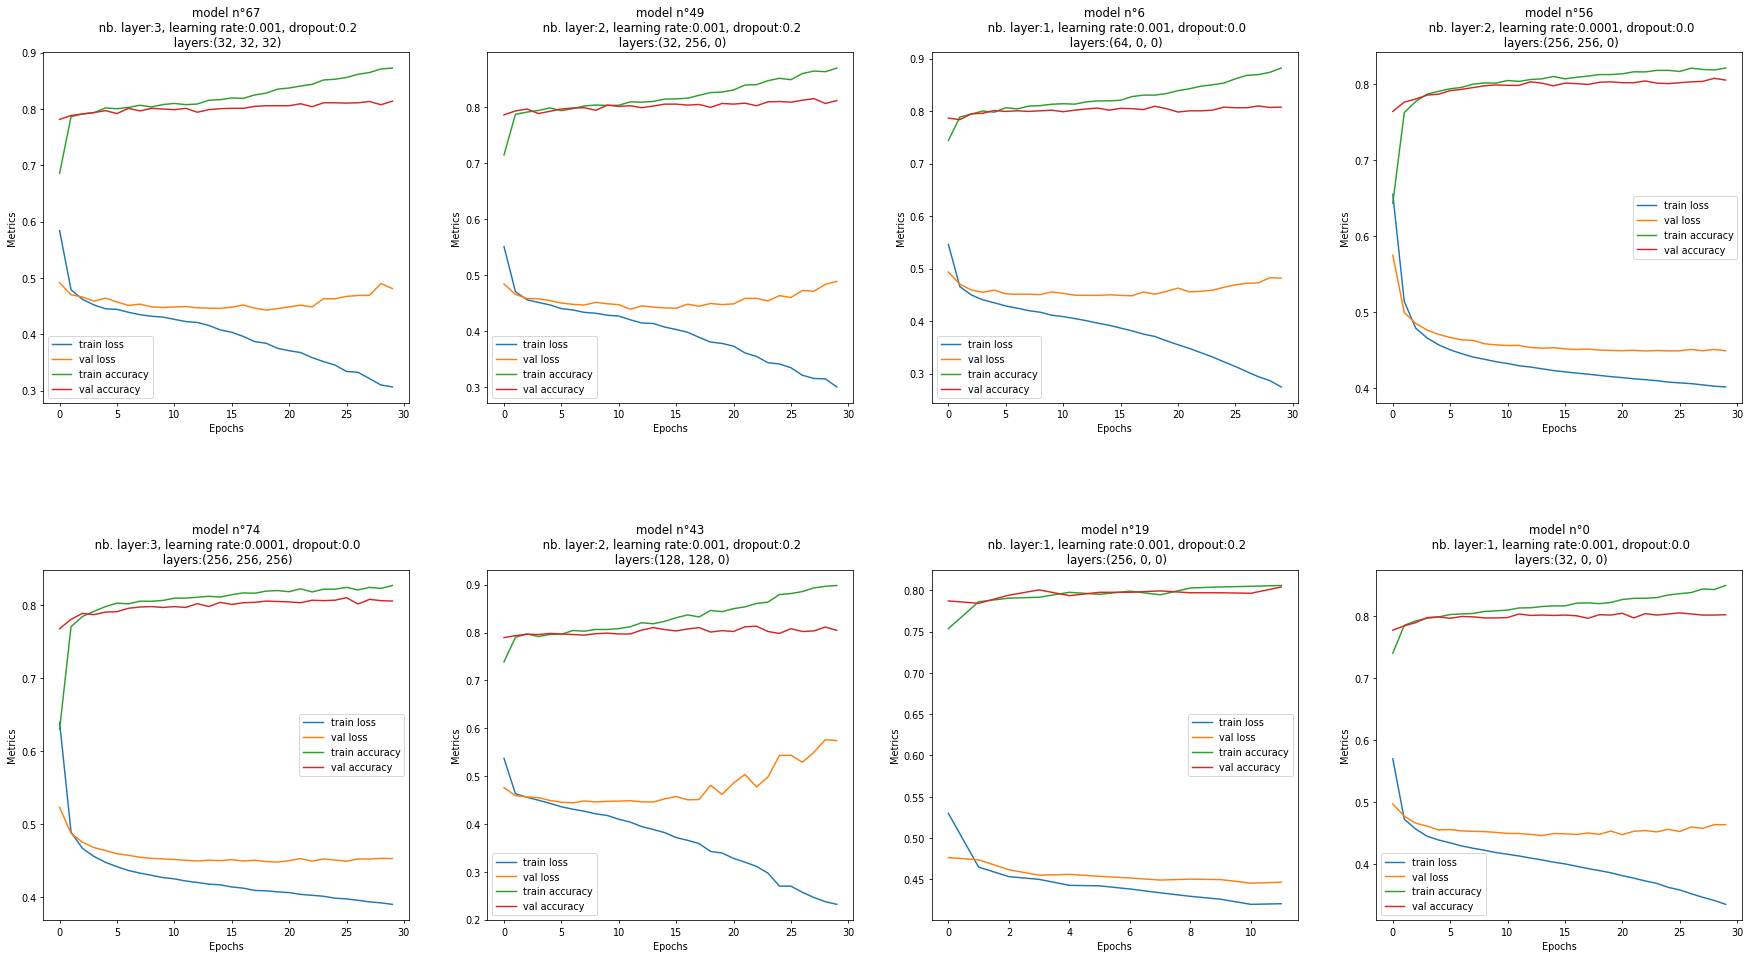

In [26]:
show_result(df_result)

In [505]:
# model = models[19]
# model.save("data/model_lstm.h5")

## Architecture RNN

In [63]:
build_models(architecture="rnn")
fit_models()

100%|██████████| 42/42 [03:15<00:00,  4.65s/it]


In [64]:
df_result = get_result()
df_result = df_result.sort_values(by=["val_accuracy", "test_acc", "val_loss", "test_loss"], ascending=False)
save_result(df_result, arch="rnn")
df_result = load_result(arch="rnn")

In [60]:
df_result

,Nb. hidden layers,learning rate,dropout,Layer 1,Layer 2,Layer 3,model_id,loss,val_loss,accuracy,val_accuracy,test_acc,test_loss,step_loss,step_val_loss,step_acc,step_val_acc
36,2,0.0010,0.0,64,64,0,36,0.446441,0.471268,0.799739,0.788863,0.783759,0.461664,"[0.5113736391067505, 0.45808568596839905, 0.44...","[0.48082077503204346, 0.4686084985733032, 0.47...","[0.7584106922149658, 0.7926334142684937, 0.799...","[0.7720417380332947, 0.7871229648590088, 0.788..."
21,1,0.0050,0.2,256,0,0,21,0.459044,0.486917,0.796694,0.786543,0.789327,0.465768,"[0.49468132853507996, 0.4590435326099396]","[0.4792066216468811, 0.48691660165786743]","[0.7720417380332947, 0.796693742275238]","[0.7708816528320312, 0.7865429520606995]"
14,1,0.0050,0.0,128,0,0,14,0.463056,0.480225,0.789443,0.784803,0.789791,0.462150,"[0.4943796992301941, 0.46305644512176514]","[0.4844558835029602, 0.4802253544330597]","[0.7747969627380371, 0.7894431352615356]","[0.7668213248252869, 0.7848027944564819]"
20,1,0.0050,0.0,256,0,0,20,0.462550,0.474442,0.795679,0.784803,0.788399,0.469847,"[0.4988574981689453, 0.4625498354434967]","[0.47658684849739075, 0.47444191575050354]","[0.7732018828392029, 0.7956786751747131]","[0.7807424664497375, 0.7848027944564819]"
24,1,0.0010,0.0,1024,0,0,24,0.458237,0.483699,0.793358,0.784803,0.784687,0.460218,"[0.4980621635913849, 0.4582365155220032]","[0.4811432957649231, 0.483699232339859]","[0.7682714462280273, 0.7933584451675415]","[0.7807424664497375, 0.7848027944564819]"
30,2,0.0010,0.0,32,32,0,30,0.447766,0.471353,0.801769,0.784223,0.780510,0.463106,"[0.515911340713501, 0.45840921998023987, 0.447...","[0.4848669767379761, 0.47859326004981995, 0.47...","[0.761600911617279, 0.7937934994697571, 0.8017...","[0.7749419808387756, 0.7807424664497375, 0.784..."
32,2,0.0050,0.0,32,32,0,32,0.459490,0.487627,0.796984,0.783643,0.786543,0.467811,"[0.4946955740451813, 0.4594896137714386]","[0.48160600662231445, 0.48762694001197815]","[0.7720417380332947, 0.7969837784767151]","[0.7871229648590088, 0.7836427092552185]"
6,1,0.0010,0.0,64,0,0,6,0.448267,0.472202,0.798579,0.783063,0.792575,0.460938,"[0.5189604163169861, 0.46034520864486694, 0.44...","[0.4922739267349243, 0.4775106906890869, 0.472...","[0.7623260021209717, 0.7924883961677551, 0.798...","[0.7732018828392029, 0.7784222960472107, 0.783..."
7,1,0.0010,0.2,64,0,0,7,0.449157,0.477079,0.797564,0.783063,0.785615,0.458776,"[0.5286234617233276, 0.46238937973976135, 0.44...","[0.4914305508136749, 0.4829574227333069, 0.477...","[0.7558004856109619, 0.7930684685707092, 0.797...","[0.7732018828392029, 0.7784222960472107, 0.783..."
12,1,0.0010,0.0,128,0,0,12,0.458442,0.473472,0.793648,0.782483,0.788399,0.462416,"[0.5082992315292358, 0.45844170451164246]","[0.48021990060806274, 0.47347182035446167]","[0.7697215676307678, 0.7936484813690186]","[0.7784222960472107, 0.7824826240539551]"


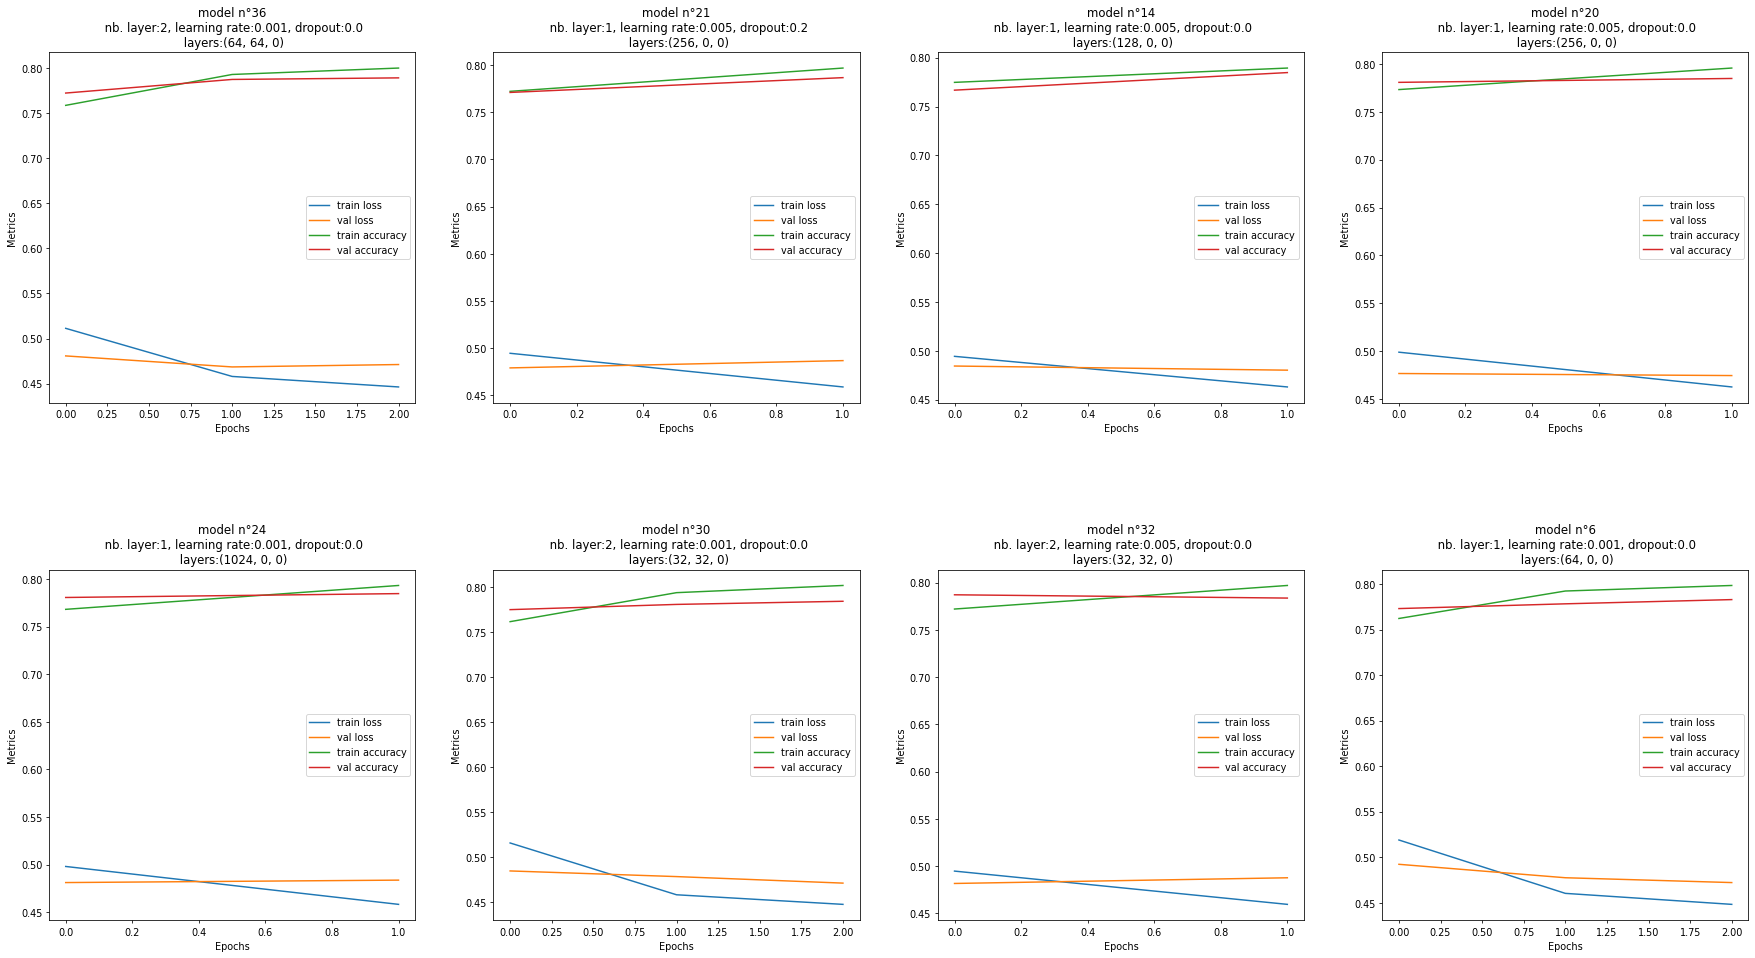

In [61]:
show_result(df_result)

In [65]:
model = models[36]
model.save("data/model_rnn.h5")

## Machine learning

In [50]:
def show_gs_result(res, param1, param2, name_param1, name_param2):
    cv_scores = np.array(res["mean_test_score"]).reshape((len(param2), len(param1)))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set(title="Learning Curves", xlabel=name_param1, ylabel="CV Score (mean)")
    for idx, val in enumerate(param2):
        sns.lineplot(x=param1, y=cv_scores[idx, :], label=name_param2 + ': ' + str(val), ax=ax)

In [68]:
clf = SGDClassifier()
clf.fit(X_train.reshape((8620, 768)), y_train.reshape(-1,))
print(f"Accuracy SGDClassifier: {round(clf.score(X_test.reshape((2155, 768)), y_test.reshape(-1,)), 2)}")

Accuracy SGDClassifier: 0.8


In [72]:
params = {"alpha": [.001, .005, .0001, .00005], "penalty": ["l2", "l1", "elasticnet"], "early_stopping":[True]}
gs = GridSearchCV(SGDClassifier(), cv=3, param_grid=params)
gs.fit(X_train.reshape((8620, 768)), y_train.reshape(-1,))
print(f"Accuracy SGDClassifier: {round(gs.score(X_test.reshape((2155, 768)), y_test.reshape(-1,)), 2)}\n(Cross Validation + Hyper parameters tunning)")

Accuracy SGDClassifier: 0.8
(Cross Validation + Hyper parameters tunning)


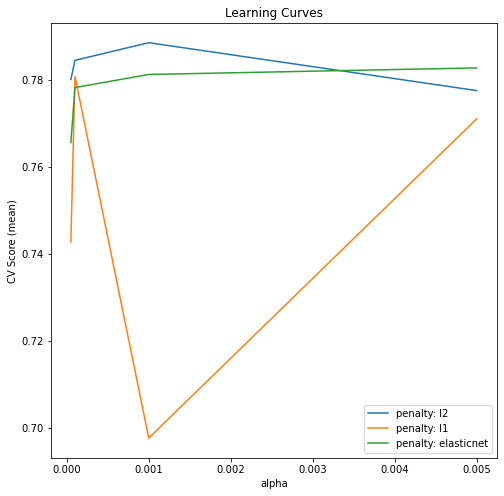

In [73]:
show_gs_result(gs.cv_results_, params["alpha"], params["penalty"], "alpha", "penalty")

In [74]:
clf = GradientBoostingClassifier(n_estimators=500)
clf.fit(X_train.reshape((8620, 768)), y_train.reshape(-1,))
clf.score(X_test.reshape((2155, 768)), y_test.reshape(-1,))

0.7958236658932715